# The error accumulation in the conjugate gradient method for degenerate problem. Anton Ryabtsev. DCAM MIPT.

In [0]:
import numpy
import numpy as np
from numpy.random import rand
from numpy import Inf
import scipy.io
import time
import random
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy.stats import special_ortho_group
import scipy.optimize
from scipy.sparse import linalg
from google.colab import files
                   

from copy import deepcopy

# Spectre generation

In [0]:
def generate_spectre(n1, n2, size, eps):    
    spectre = []
    for i in range(size//2):
        noise = random.uniform(-eps, eps)        
        spectre = [n1 + noise] + spectre
        noise = random.uniform(-eps, eps)
        spectre.append(n2 + noise)
    if size % 2 == 1:
        noise = random.uniform(-eps, eps)
        spectre.append(n2 + noise)
    return spectre

# Plotting spectre

In [0]:
def plot_spectrum(coordinates):
    
    # Draw horizontal line
    plt.hlines(0, np.min(coordinates) - 1, np.max(coordinates) + 1)
    plt.xlim(np.min(coordinates) - 1, np.max(coordinates) + 1)
    plt.ylim(-0.5, 0.5)
    
    # Draw eig-values points
    y = np.zeros(np.shape(coordinates))
    plt.plot(coordinates, y, '|', label="Eigenvalues", ms = 10)
    plt.xlabel('Eigenvalues', fontsize=15)
    fig = plt.gcf()
    fig.set_size_inches(20, 2.2)
    plt.legend(loc="best", fontsize=12)
    plt.yticks([])
    plt.savefig('Spectrum.pdf')
    plt.show()

# Generating function and gradient

In [0]:
def qf_params(A, b, n, M_inv=None):
    if (np.array_equal(A, A.T) == False):
        A = 0.5 * (A + A.T)
    return {'f': lambda x: 0.5 * (x.T @ A @ x) - b.T @ x, 'grad': lambda x: 0.5 * (A + A.T) @ x - b, 'n': n}

# Creating noisy matrixes and vecs

## Noisy vector generation

$\|b\|_2 = \sqrt{b_1^2 + b_2^2 + ... + b_n^2}$

$\|\tilde{b} - b\|_2 = \sqrt{(\tilde{b}_1 - b_1)^2 + (\tilde{b}_2 - b_2)^2 + ... + (\tilde{b}_n - b_n)^2} < \delta_b$

$\|\tilde{b} - b\|_2 = \sqrt{\Delta_1^2 + \Delta_2^2 + ... + \Delta_n^2} < \delta_b$

$\Delta_1^2 + \Delta_2^2 + ... + \Delta_n^2 < \delta_b^2$

$\Delta_1 = random.uniform(-\delta_b, \delta_b)$

$\Delta_2 = random.uniform(-\sqrt{\delta_b^2 - \Delta_1^2}, \sqrt{\delta_b^2 - \Delta_1^2})$

$\Delta_3 = random.uniform(-\sqrt{\delta_b^2 - \Delta_1^2 - \Delta_2^2}, \sqrt{\delta_b^2 - \Delta_1^2 - \Delta_2^2})$

...

## Noisy matrix generation

$
\|\tilde{A} - A\|_2 < \delta_A
$

$
\tilde{A} = A + \delta\cdot I, 
$

$
\tilde{A} - A = \delta\cdot I
$

$
\|\delta\cdot I\|_2 < \delta_A
$

$
0 < \delta < \delta_A
$

$
\delta = random.uniform(0, \delta_A)\;\;\; or \;\;\; \delta = random.gauss(0, \frac{\delta_A}{3})
$

In [0]:
def make_noisy_object(linspace_object, delta):
    if len(linspace_object.shape) == 2: # means that object is a matrix        
        I = np.eye(linspace_object.shape[0])        
        d = random.uniform(-delta, delta)
#         d = random.gauss(0, delta/3)
        dI = d * I        
        noisy_linspace_object = linspace_object + dI
        
    else:
        deltas = np.zeros(len(linspace_object))
        deltas[0] = (np.random.uniform(-delta, delta))
        i = 1
        while i < len(linspace_object) and np.sum(np.array(deltas)**2) < delta**2:
            deltas[i] = (np.random.uniform(-np.sqrt(delta**2 - np.sum(np.array(deltas)**2)),\
                                           np.sqrt(delta**2 - np.sum(np.array(deltas)**2))))
            i += 1
                     
        noisy_linspace_object = linspace_object + deltas
    
    return noisy_linspace_object

# My solver

In [0]:
class CG_solver():
    def __init__(self, starter_A, starter_b, accuracy=10**-3, factor=10, A=None, b=None):        
        func = qf_params(starter_A, starter_b, starter_A.shape[0])
        self.accuracy = accuracy
        self.factor = factor
        if A is not None:
            self.A = A
            self.starter_A = starter_A
        else:
            self.A = starter_A
        if b is not None:
            self.b = b
            self.starter_b = starter_b
        else:
            self.b = starter_b
        func = qf_params(self.A, self.b, self.A.shape[0])
        self.f = func['f']
        self.grad = func['grad']
        self.n = func['n']

        self.d = -func['grad'](x0)
        self.alpha = 0
    
    def calculate_alpha(self, x):
        d = self.d
        grad = self.grad
        alpha = -float(d.T @ grad(x)) / float(d.T @ self.A @ d)
        return alpha
    
    def calculate_beta(self, x, dx):
        d = self.d
        grad = self.grad
        beta = float(grad(x) @ self.A @ d) / float(d.T @ self.A @ d)
        
        print(f'grad(x): {np.linalg.norm(grad(x))}')
        return beta
    
    def solve(self, x0, save_trajectory=True, variable_tilde_A=False, variable_tilde_b=False,\
              delta_A=None, delta_b=None):        
        g = self.grad(x0)
        i = 0
        errors = []
        trajectory = []
        gradient_traj = []
        gradient_traj.append(np.linalg.norm(g, ord=2))
        trajectory.append(deepcopy(x0))
        x = deepcopy(x0)
        
        while(np.linalg.norm(g, ord=2) > self.accuracy and i < self.n * self.factor):
            print(f'i: {i}')
            i += 1
            dx = self.calculate_alpha(x) * self.d            
            x += dx#           
            g = self.grad(x)
            gradient_traj.append(np.linalg.norm(g, ord=2))
            beta = self.calculate_beta(x, dx)
            self.d = -g + beta * self.d
            if variable_tilde_A:
                self.A = make_noisy_object(self.starter_A, delta_A)
            if variable_tilde_b:
                self.b = make_noisy_object(self.starter_b, delta_b)                
            if (variable_tilde_A or variable_tilde_b):
                func = qf_params(self.A, self.b, self.A.shape[0])
                self.f = func['f']
                self.grad = func['grad']
            trajectory.append(deepcopy(x))
        if save_trajectory:
            return {'trajectory' : trajectory, 'grad' : gradient_traj, "num_iter": i}
        else:
            return {'x' : self.x, "num_iter": i}

# 1.  $N = 10, accuracy = 10^{-5}$

In [0]:
N = 10
spectre = generate_spectre(0.01, 130000, int(N), 0.008)
di = np.diag(spectre)


x = special_ortho_group.rvs(N)

In [10]:
B = x @ di @ x.T
b = rand(B.shape[0])
print(f'Det: {np.linalg.slogdet(B)[1]}, cond: {np.linalg.cond(B)}')

Det: 35.21496149695322, cond: 43587535.13845389


In [0]:
func1 = qf_params(B, b, B.shape[0])

x0 = np.zeros(func1['n'])
# x0 = np.random.uniform(-100, 100, func1['n'])

In [16]:
solver1 = CG_solver(B, b)
res1 = solver1.solve(x0, verbose=False)

i: 0
grad(x): 1.7096991814933438
i: 1
grad(x): 0.798493213524474
i: 2
grad(x): 1.9446094156661702
i: 3
grad(x): 0.43566591603852933
i: 4
grad(x): 2.3140103798435323
i: 5
grad(x): 0.14483932806341382
i: 6
grad(x): 0.5262173936270521
i: 7
grad(x): 0.010962038107844038
i: 8
grad(x): 0.04616850028572902
i: 9
grad(x): 0.002345977738587702
i: 10
grad(x): 6.088094723083733e-09


In [0]:
noisy_B = make_noisy_object(B, 10**-5)
noisy_b = make_noisy_object(b, 10**-5)

func2 = qf_params(noisy_B, noisy_b, noisy_B.shape[0])

In [0]:
solver2 = CG_solver(starter_A=B, starter_b=b, A=noisy_B, b=noisy_b)

In [19]:
res2 = solver2.solve(x0, verbose=False, variable_tilde_A=True, variable_tilde_b=True, delta_A=10**-5, delta_b=10**-5)
# res2 = solver2.solve(x0, verbose=False, variable_tilde_A=False, variable_tilde_b=True, delta_b=10**-1)

i: 0
grad(x): 1.7097005346950203
i: 1
grad(x): 0.7986617761569338
i: 2
grad(x): 1.9460958639992973
i: 3
grad(x): 24.506438381737144
i: 4
grad(x): 0.43247457523423494
i: 5
grad(x): 103.20581869419995
i: 6
grad(x): 2.363136710841107
i: 7
grad(x): 1.59572288621724
i: 8
grad(x): 3.766490328598287
i: 9
grad(x): 1.3524605363776057
i: 10
grad(x): 0.4818874983863413
i: 11
grad(x): 4.46453562716321
i: 12
grad(x): 2.74085838319088
i: 13
grad(x): 4.053837314900208
i: 14
grad(x): 4.849756487059054
i: 15
grad(x): 2.5974621925909753
i: 16
grad(x): 1.0995703740701042
i: 17
grad(x): 2.0272411912651527
i: 18
grad(x): 1.3864200182464212
i: 19
grad(x): 1.6309645335150431
i: 20
grad(x): 3.890488737400563
i: 21
grad(x): 4.375447177964327
i: 22
grad(x): 0.9895876849810422
i: 23
grad(x): 0.8411707091662045
i: 24
grad(x): 2.4011370551683613
i: 25
grad(x): 0.47927835669730123
i: 26
grad(x): 1.1215682725831055
i: 27
grad(x): 4.193897534827282
i: 28
grad(x): 2.661316148660052
i: 29
grad(x): 1.444713601241443
i: 

In [0]:
len(res2['trajectory'])

2001

In [0]:
basic_x_stop = len(res1['trajectory'])
basic_y_stop = func1['f'](res1['trajectory'][-1])
trajectory_for_gradient = res1['trajectory']
res1['trajectory'] = res1['trajectory'] + [res1['trajectory'][-1]] * (len(res2['trajectory']) - len(res1['trajectory']))

In [32]:
print(f"orig  f*: {func1['f'](res2['trajectory'][-1])}\nnoisy f*: {func1['f'](res1['trajectory'][-1])}\nerror: {np.abs(func1['f'](res2['trajectory'][-1]) - func1['f'](res1['trajectory'][-1]))}")

orig  f*: -149.4748631186161
noisy f*: -160.40713043366787
error: 10.932267315051774


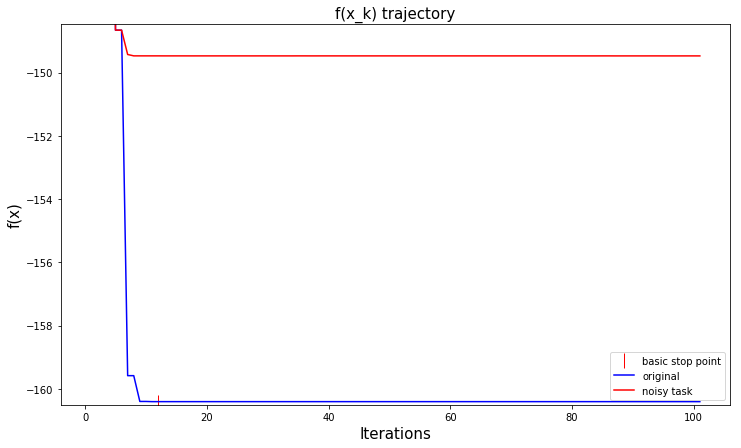

In [33]:
f = plt.figure(figsize=(12,7))
plt.plot(basic_x_stop, basic_y_stop, 'r|', label='basic stop point', ms = 15)
plt.plot(np.linspace(1, len(res1['trajectory']), len(res1['trajectory'])), [func1['f'](res1['trajectory'][i]) for i in range(len(res1['trajectory']))], color='b', label='original')
plt.plot(np.linspace(1, len(res2['trajectory']), len(res2['trajectory'])), [func1['f'](res2['trajectory'][i]) for i in range(len(res2['trajectory']))], color='r', label='noisy task')
plt.ylim(func1['f'](res1['trajectory'][-1]) - 0.1, func1['f'](res2['trajectory'][-1]) + 1)
# plt.xlim(-0.1, 10)
plt.title('f(x_k) trajectory', fontsize=15)
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('f(x)', fontsize=15)
plt.legend()
plt.show()
f.savefig("res1_2.pdf", bbox_inches='tight')

## Траектория нормы градиента: 

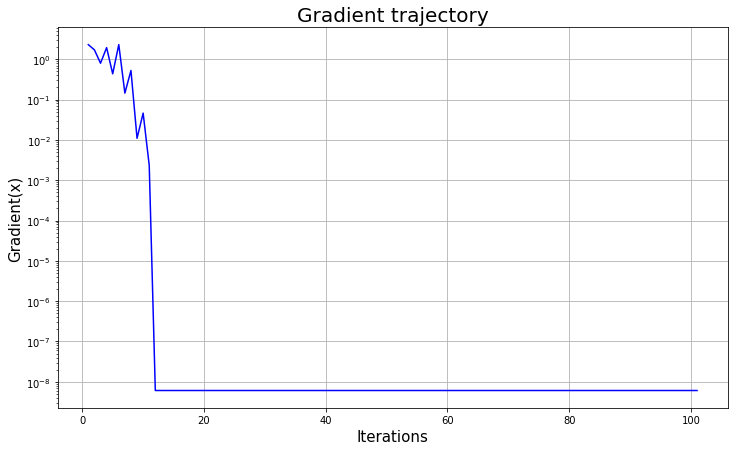

In [34]:
plt.figure(figsize=(12,7))
plt.semilogy(np.linspace(1, len(trajectory_for_gradient), len(trajectory_for_gradient)), [np.linalg.norm(func1['grad'](trajectory_for_gradient[i])) for i in range(len(trajectory_for_gradient))], color='b')
plt.title('Gradient trajectory', fontsize=20)
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('Gradient(x)', fontsize=15)
plt.grid()
plt.show()

## Траектория нормы градиента для шумной задачи: 

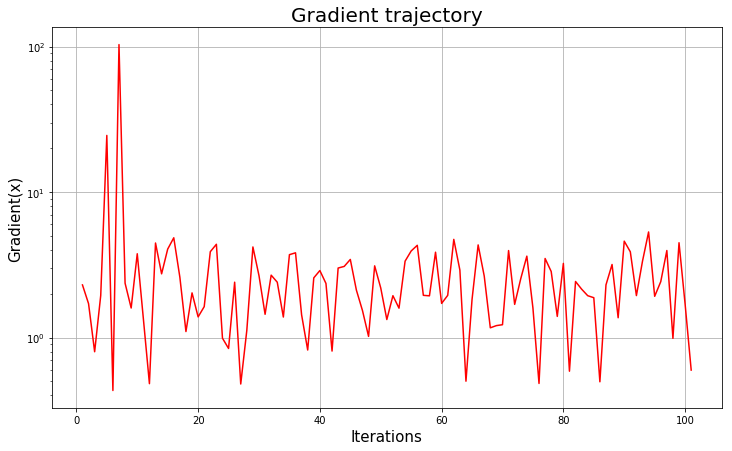

In [36]:
plt.figure(figsize=(12,7))
plt.semilogy(np.linspace(1, len(res2['grad']), len(res2['grad'])), res2['grad'], color='r')
plt.title('Gradient trajectory', fontsize=20)
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('Gradient(x)', fontsize=15)
plt.grid()
plt.show()

In [0]:
from scipy.optimize import minimize

In [0]:
func = qf_params(B, b, B.shape[0])

In [39]:
res = minimize(func['f'], x0, method='CG', jac=func['grad'], options={'disp': True})

         Current function value: -160.284889
         Iterations: 10
         Function evaluations: 117
         Gradient evaluations: 105


# 2. $N = 100; accuracy = 10^{-6}$

In [0]:
N = 100
spectre = generate_spectre(0.01, 130000, int(N), 0.008)
di = np.diag(spectre)


x = special_ortho_group.rvs(N)

In [41]:
B = x @ di @ x.T
b = rand(B.shape[0])
print(f'Det: {np.linalg.slogdet(B)[1]}, cond: {np.linalg.cond(B)}')

Det: 350.2121332277545, cond: 59224028.63128415


In [0]:
func1 = qf_params(B, b, B.shape[0])

x0 = np.zeros(func1['n'])
# x0 = np.random.uniform(-100, 100, func1['n'])

In [51]:
solver1 = CG_solver(B, b)
res1 = solver1.solve(x0, verbose=False)

i: 0
grad(x): 5.49780260423694
i: 1
grad(x): 2.579205425838256
i: 2
grad(x): 2.886542153545783
i: 3
grad(x): 1.3555974502758505
i: 4
grad(x): 1.3271815354271572
i: 5
grad(x): 0.6640091690881349
i: 6
grad(x): 0.7227475491955828
i: 7
grad(x): 0.3871940330788959
i: 8
grad(x): 0.38947830463650684
i: 9
grad(x): 0.20382709261444246
i: 10
grad(x): 0.1856094056458556
i: 11
grad(x): 0.1395391762273035
i: 12
grad(x): 0.06476637189205336
i: 13
grad(x): 0.14225993458085837
i: 14
grad(x): 0.020815616204847936
i: 15
grad(x): 0.25131537904253565
i: 16
grad(x): 0.010405539002071008
i: 17
grad(x): 0.4517646713982953
i: 18
grad(x): 0.004016875888881661
i: 19
grad(x): 0.8967206195488739
i: 20
grad(x): 0.001794073558437982
i: 21
grad(x): 1.7187887212554753
i: 22
grad(x): 0.0009426205664967769


In [0]:
noisy_B = make_noisy_object(B, 10**-6)
noisy_b = make_noisy_object(b, 10**-6)

func2 = qf_params(noisy_B, noisy_b, noisy_B.shape[0])

In [0]:
solver2 = CG_solver(starter_A=B, starter_b=b, factor=100, A=noisy_B, b=noisy_b)

In [46]:
res2 = solver2.solve(x0, verbose=False, variable_tilde_A=True, variable_tilde_b=True, delta_A=10**-6, delta_b=10**-6)
# res2 = solver2.solve(x0, verbose=False, variable_tilde_A=False, variable_tilde_b=True, delta_b=10**-1)

i: 0
grad(x): 5.497802916033027
i: 1
grad(x): 2.579281493991643
i: 2
grad(x): 2.8866937555694463
i: 3
grad(x): 6.197068142896912
i: 4
grad(x): 0.9596405386417285
i: 5
grad(x): 20.092708576809745
i: 6
grad(x): 0.48901380484295986
i: 7
grad(x): 82.13506221653998
i: 8
grad(x): 0.290329705304881
i: 9
grad(x): 130.44153474403677
i: 10
grad(x): 0.168659518441545
i: 11
grad(x): 1.0108017336722812
i: 12
grad(x): 0.18379105946363639
i: 13
grad(x): 0.3235548570284388
i: 14
grad(x): 0.188254857272904
i: 15
grad(x): 0.4077852061886832
i: 16
grad(x): 0.1762415995467808
i: 17
grad(x): 0.3822922216532418
i: 18
grad(x): 0.17742533449626016
i: 19
grad(x): 0.4532110615710631
i: 20
grad(x): 0.1626995347350594
i: 21
grad(x): 3.584624994234348
i: 22
grad(x): 0.162496758844929
i: 23
grad(x): 0.5568867321231745
i: 24
grad(x): 0.1574642754051805
i: 25
grad(x): 1.1385225587465677
i: 26
grad(x): 0.15526331195072937
i: 27
grad(x): 1.1872851332300356
i: 28
grad(x): 0.1523318896823162
i: 29
grad(x): 18.84422438457

In [0]:
basic_x_stop = len(res1['trajectory'])
basic_y_stop = func1['f'](res1['trajectory'][-1])
trajectory_for_gradient = res1['trajectory']
res1['trajectory'] = res1['trajectory'] + [res1['trajectory'][-1]] * (len(res2['trajectory']) - len(res1['trajectory']))

In [48]:
print(f"orig  f*: {func1['f'](res2['trajectory'][-1])}\nnoisy f*: {func1['f'](res1['trajectory'][-1])}\nerror: {np.abs(func1['f'](res2['trajectory'][-1]) - func1['f'](res1['trajectory'][-1]))}")

orig  f*: -1094.176168268527
noisy f*: -1094.2877871481144
error: 0.11161887958746775


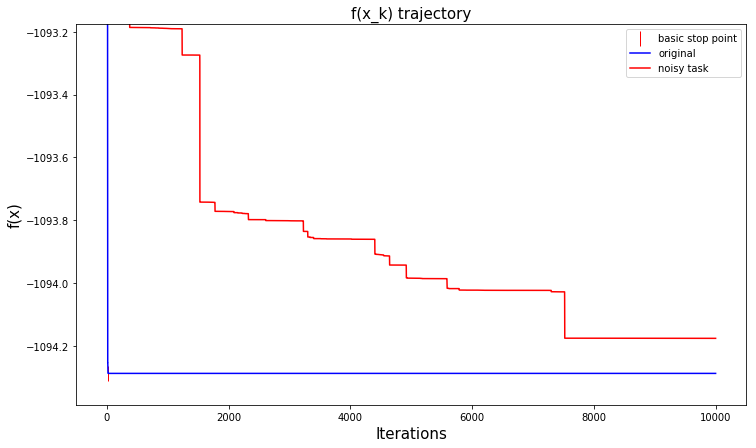

In [49]:
f = plt.figure(figsize=(12,7))
plt.plot(basic_x_stop, basic_y_stop, 'r|', label='basic stop point', ms = 15)
plt.plot(np.linspace(1, len(res1['trajectory']), len(res1['trajectory'])), [func1['f'](res1['trajectory'][i]) for i in range(len(res1['trajectory']))], color='b', label='original')
plt.plot(np.linspace(1, len(res2['trajectory']), len(res2['trajectory'])), [func1['f'](res2['trajectory'][i]) for i in range(len(res2['trajectory']))], color='r', label='noisy task')
plt.ylim(func1['f'](res1['trajectory'][-1]) - 0.1, func1['f'](res2['trajectory'][-1]) + 1)
# plt.xlim(-0.1, 10)
plt.title('f(x_k) trajectory', fontsize=15)
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('f(x)', fontsize=15)
plt.legend()
plt.show()
f.savefig("res1_2.pdf", bbox_inches='tight')

## Траектория нормы градиента: 

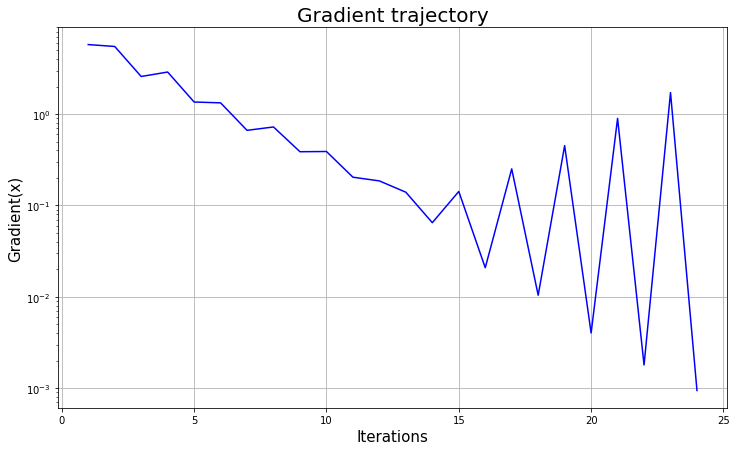

In [53]:
plt.figure(figsize=(12,7))
plt.semilogy(np.linspace(1, len(trajectory_for_gradient), len(trajectory_for_gradient)), [np.linalg.norm(func1['grad'](trajectory_for_gradient[i])) for i in range(len(trajectory_for_gradient))], color='b')
plt.title('Gradient trajectory', fontsize=20)
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('Gradient(x)', fontsize=15)
plt.grid()
plt.show()

# 3. The same as (1.) but $x_0$ is a random point

In [0]:
N = 10
spectre = generate_spectre(0.01, 130000, int(N), 0.008)
di = np.diag(spectre)


x = special_ortho_group.rvs(N)

In [55]:
B = x @ di @ x.T
b = rand(B.shape[0])
print(f'Det: {np.linalg.slogdet(B)[1]}, cond: {np.linalg.cond(B)}')

Det: 33.25938422307411, cond: 48998125.51922141


In [0]:
func1 = qf_params(B, b, B.shape[0])

# x0 = np.zeros(func1['n'])
x0 = np.random.uniform(-1000, 1000, func1['n'])

In [86]:
solver1 = CG_solver(B, b)
res1 = solver1.solve(x0, verbose=False)

i: 0
grad(x): 11.49331651057612
i: 1
grad(x): 60.846945834722035
i: 2
grad(x): 2.3284654481865115
i: 3
grad(x): 8.040502658826128
i: 4
grad(x): 0.42656481826277803
i: 5
grad(x): 1.403128649334539
i: 6
grad(x): 0.08841124693326544
i: 7
grad(x): 0.17708492921910438
i: 8
grad(x): 0.018919612167770317
i: 9
grad(x): 0.011160642087155791
i: 10
grad(x): 0.046371736043351514
i: 11
grad(x): 4.018040940428738e-08


In [0]:
noisy_B = make_noisy_object(B, 10**-5)
noisy_b = make_noisy_object(b, 10**-5)

func2 = qf_params(noisy_B, noisy_b, noisy_B.shape[0])

In [0]:
solver2 = CG_solver(starter_A=B, starter_b=b, factor=300, A=noisy_B, b=noisy_b)

In [78]:
res2 = solver2.solve(x0, verbose=False, variable_tilde_A=True, variable_tilde_b=True, delta_A=10**-5, delta_b=10**-5)
# res2 = solver2.solve(x0, verbose=False, variable_tilde_A=False, variable_tilde_b=True, delta_b=10**-1)

i: 0
grad(x): 11.481148036013407
i: 1
grad(x): 60.764951718071934
i: 2
grad(x): 3.1816942467904648
i: 3
grad(x): 3.15434876374948
i: 4
grad(x): 46.093816242530714
i: 5
grad(x): 0.4098269577179398
i: 6
grad(x): 423.33159364181256
i: 7
grad(x): 0.8300995899944984
i: 8
grad(x): 0.2734091351890685
i: 9
grad(x): 0.25951196032228707
i: 10
grad(x): 1.95029041394501
i: 11
grad(x): 0.9034487160419781
i: 12
grad(x): 0.35820158305581085
i: 13
grad(x): 0.36212137970759983
i: 14
grad(x): 0.46750239521373504
i: 15
grad(x): 0.3746509473993416
i: 16
grad(x): 0.559800747689916
i: 17
grad(x): 0.4554729037222829
i: 18
grad(x): 1.498790512360274
i: 19
grad(x): 0.3056133971363943
i: 20
grad(x): 2.2611153223076523
i: 21
grad(x): 0.7847988225208743
i: 22
grad(x): 0.8843408732129105
i: 23
grad(x): 0.4469183916655791
i: 24
grad(x): 0.37560012889434774
i: 25
grad(x): 0.3914320137852765
i: 26
grad(x): 0.31410489428217464
i: 27
grad(x): 0.25477120328933256
i: 28
grad(x): 8.951453971032592
i: 29
grad(x): 0.3102759

In [0]:
basic_x_stop = len(res1['trajectory'])
basic_y_stop = func1['f'](res1['trajectory'][-1])
trajectory_for_gradient = res1['trajectory']
res1['trajectory'] = res1['trajectory'] + [res1['trajectory'][-1]] * (len(res2['trajectory']) - len(res1['trajectory']))

In [88]:
print(f"orig  f*: {func1['f'](res2['trajectory'][-1])}\nnoisy f*: {func1['f'](res1['trajectory'][-1])}\nerror: {np.abs(func1['f'](res2['trajectory'][-1]) - func1['f'](res1['trajectory'][-1]))}")

orig  f*: -209.08977837102097
noisy f*: -209.52530985453473
error: 0.43553148351375626


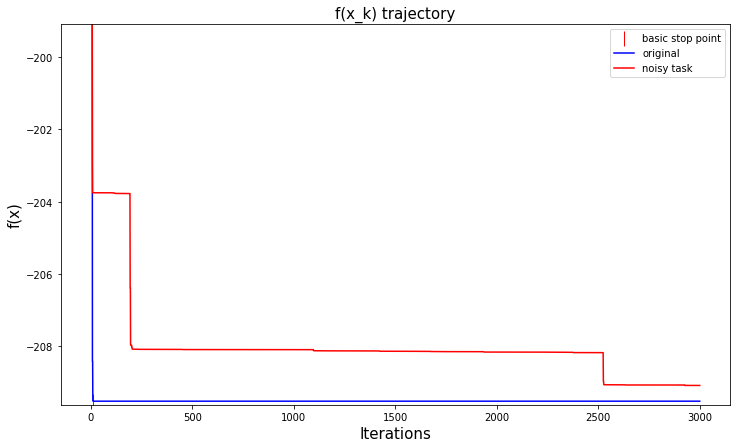

In [89]:
f = plt.figure(figsize=(12,7))
plt.plot(basic_x_stop, basic_y_stop, 'r|', label='basic stop point', ms = 15)
plt.plot(np.linspace(1, len(res1['trajectory']), len(res1['trajectory'])), [func1['f'](res1['trajectory'][i]) for i in range(len(res1['trajectory']))], color='b', label='original')
plt.plot(np.linspace(1, len(res2['trajectory']), len(res2['trajectory'])), [func1['f'](res2['trajectory'][i]) for i in range(len(res2['trajectory']))], color='r', label='noisy task')
plt.ylim(func1['f'](res1['trajectory'][-1]) - 0.1, func1['f'](res2['trajectory'][-1]) + 10)
# plt.xlim(-0.1, 10)
plt.title('f(x_k) trajectory', fontsize=15)
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('f(x)', fontsize=15)
plt.legend()
plt.show()
f.savefig("res1_2.pdf", bbox_inches='tight')

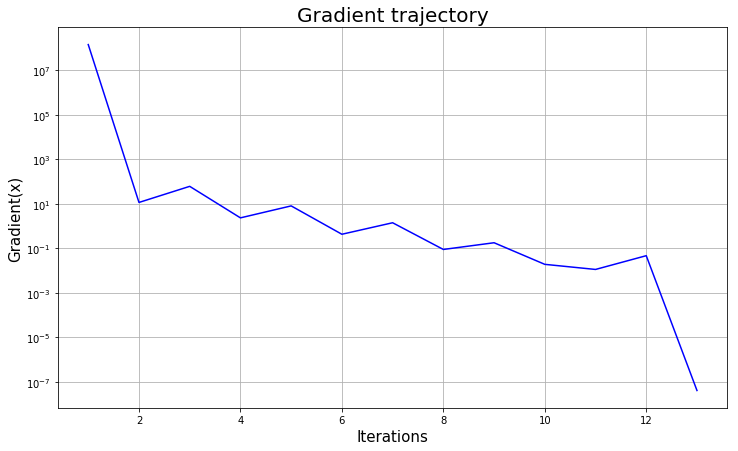

In [90]:
plt.figure(figsize=(12,7))
plt.semilogy(np.linspace(1, len(trajectory_for_gradient), len(trajectory_for_gradient)), [np.linalg.norm(func1['grad'](trajectory_for_gradient[i])) for i in range(len(trajectory_for_gradient))], color='b')
plt.title('Gradient trajectory', fontsize=20)
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('Gradient(x)', fontsize=15)
plt.grid()
plt.show()